In [1]:
import pandas as pd
# Load the CSV file (update the path to your actual file)
from sklearn.model_selection import train_test_split
from collections import defaultdict
import numpy as np
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv("email_spam.csv")  # 'latin-1' works for special characters
train_x,test_x = train_test_split(df,test_size=0.2,random_state=7)
spam_count = defaultdict(int)
ham_count = defaultdict(int)
print(df.head)

<bound method NDFrame.head of           Id  spam                                               text
0        1.0   1.0  Subject: naturally irresistible your corporate...
1        2.0   1.0  Subject: the stock trading gunslinger  fanny i...
2        3.0   1.0  Subject: unbelievable new homes made easy  im ...
3        4.0   1.0  Subject: 4 color printing special  request add...
4        5.0   1.0  Subject: do not have money , get software cds ...
...      ...   ...                                                ...
2905  2909.0   0.0  Subject: re : term papers  please respond to  ...
2906  2910.0   0.0  Subject: re : actions on anjam ' s resignation...
2907  2911.0   0.0  Subject: india database  jim / wade ,  as you ...
2908  2912.0   0.0  Subject: re : invitation - wharton et events  ...
2909  2913.0   0.0  Subject: moze cie to zainteresuje  vince ,  da...

[2910 rows x 3 columns]>


In [3]:
def split_cust(email,freq):
    words=[]
    common_words = set(['a','as','are','at','to','too','or','and','subject','what','when','not','re','let'])

    email =email.lower()
    i=0
    j=0
    count=0
    while (i<len(email)):
        while((i<len(email))and(email[i]!=' ' and email[i]!='\n' and email[i]!='\t' and email[i]!=',' and email[i]!='-' and email[i]!=':' and email[i]!='.' and email[i]!= "'" and email[i]!='"')):
            i+=1
        word = email[j:i]
        while((i<len(email))and(email[i]==' ' or email[i]=='\n' or email[i]=='\t' or email[i]==',' or email[i]=='-' or email[i]==':' or email[i]=='.' or email[i]== "'" or email[i]=='"' )):
            i+=1
        j=i
        #print(word)
        if  word not in common_words and word != '':
            words.append(word)
            freq[word]+=1
            count+=1
    return words,count


In [14]:
spam_mail = train_x[ train_x['spam']==1]['text']
spam_mail = list(spam_mail)

ham_mail = train_x[ train_x['spam']==0]['text']
ham_mail = list(ham_mail)

prob_spam = len(spam_mail)/len(df)
prob_ham = len(ham_mail)/len(df)
print(len(spam_mail))

1101


In [5]:
words_spam=set()
spam_word_count=0
for s in spam_mail:
    word,count=(split_cust(s,spam_count))
    words_spam = words_spam | set(word)
    spam_word_count+=count

words_ham=set()
ham_word_count =0
for s in ham_mail:
    word,count=(split_cust(s,ham_count))
    words_ham|=set(word)
    ham_word_count+=count

 


finding probability of occurance of word

In [6]:
prob_word_spam = defaultdict(float)
unique = words_spam | words_ham
for w in words_spam:
    prob_word_spam[w] = (spam_count[w]+1)/(spam_word_count+len(unique))
prob_word_ham = defaultdict(float)
for w in words_ham:
    prob_word_ham[w]= (ham_count[w]+1)/(ham_word_count+len(unique))


# testing phase

In [7]:
def predict (s):
    
    freq_count = defaultdict(int)
    words,count = split_cust(s,freq_count)
    p_spam =0
    p_ham = 0
    
    for w in words:
        if(prob_word_spam[w]==0):
            prob_word_spam[w]=1/(spam_word_count+len(unique))
        p_spam += np.log(prob_word_spam[w])
        if(prob_word_ham[w]==0):
            prob_word_ham[w]=1/(ham_word_count+len(unique))
        p_ham += np.log(prob_word_ham[w])
    p_spam+=np.log(prob_spam)
    p_ham += np.log(prob_ham)
    if p_spam>p_ham:
        return 1.0
    return 0.0


In [8]:
predict_label=[]
for s in test_x['text']:
    predict_label.append(predict(s))
label = list(test_x['spam'])

In [9]:
accuracy = accuracy_score(label, predict_label)
print("Accuracy using sklearn:", accuracy)


Accuracy using sklearn: 0.993127147766323


In [10]:
from sklearn.metrics import classification_report

print(classification_report(np.array(predict_label),np.array(test_x['spam'])))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       311
         1.0       1.00      0.99      0.99       271

    accuracy                           0.99       582
   macro avg       0.99      0.99      0.99       582
weighted avg       0.99      0.99      0.99       582



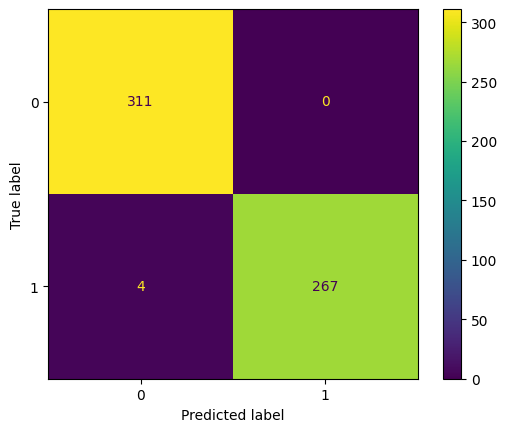

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(np.array(predict_label),np.array(test_x['spam']))
ConfusionMatrixDisplay(cm).plot()

# dataset :https://www.kaggle.com/datasets/jayaprakashpondy/email-spam

In [12]:
import json
model_data={
    "number_of_words" : len(unique),
    "spam_word_count" : spam_word_count,
    "ham_word_count" : ham_word_count,
    "prob_word_spam" : prob_word_spam,
    "prob_word_ham" : prob_word_ham,
    "prob_spam" : prob_spam,
    "prob_ham" : prob_ham
}
with open("model.json",'w') as file:
    json.dump(model_data,file)
